# Effect size extrapolation

In the [last notebook], we calculated emperical and distribution-based power for five types of statistical tests:
* One Sample T test
* Independent Sample t test 
* One way ANOVA, 3 groups
* One way ANOVA, 8 groups
* Linear correlation

We will now evaluate 

In [1]:
import copy
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy
# import statsmodels.api as sms
import statsmodels.formula.api as smf

import emp_power.traditional as trad
import emp_power.effects as eff
import emp_power.plot as plot

% matplotlib inline
sn.set_style('ticks')

In [2]:
warnings.filterwarnings('ignore')

In [3]:
num_rounds = 100
alpha = 0.05
counts = np.arange(5, 100, 10)
colormap = 'Spectral'
overwrite = True

In [4]:
sim_location = './simulations'
if not os.path.exists(sim_location):
    raise ValueError('The power simulations do not exist.'
                     'Please go back to notebooks 2 and 3 and'
                     'calculate power.'
                     )

In [5]:
colors = sn.color_palette(colormap, n_colors=len(counts))
check_color = {count: colors[i] for i, count in enumerate(counts)}

In [6]:
tests = ['ttest_1', 'ttest_ind', 'anova_3', 'anova_8', 'correlation']
# tests = ['ttest_1']

In [7]:
extrapolated = ['f_power', 't_power', 'z_power']

In [8]:
distributions = {'ttest_1': {'clean_name': 'One Sample\nT Test',
                               'num_groups': 2,
                               'input_dir': './simulations/emperical_power/ttest_1',
                               'return_fp': './simulations/extrapolation/ttest_1.txt'
                               },
                 'ttest_ind': {'clean_name': 'Independent Sample\n T Test',
                               'num_groups': 2,
                               'input_dir': './simulations/emperical_power/ttest_ind',
                               'return_fp': './simulations/extrapolation/ttest_ind.txt'
                               },
                 'anova_3': {'clean_name': 'One way ANOVA\n(3 groups)',
                             'num_groups': 3,
                             'input_dir': './simulations/emperical_power/anova_3',
                             'return_fp': './simulations/extrapolation/anova_3.txt'
                             },
                 'anova_8': {'clean_name': 'One way ANOVA\n(8 groups)',
                             'num_groups': 8,
                             'input_dir': './simulations/emperical_power/anova_8',
                             'return_fp': './simulations/extrapolation/anova_8.txt'
                             },
                 'correlation': {'clean_name': 'Correlation',
                                 'num_groups': 2,
                                 'input_dir': './simulations/emperical_power/correlation',
                                 'return_fp': './simulations/extrapolation/correlation.txt'
                                 }
                 }

We'll start by calculating the emperical and extrapolated effect sizes for the parametric tests.

In [9]:
for test_name in tests:
    power_dir = distributions[test_name]['input_dir']
    num_groups = distributions[test_name]['num_groups']
    return_fp = distributions[test_name]['return_fp']
    
    if not os.path.exists(power_dir):
        raise ValueError('%s does not exist' % power_dir)
        
    summaries = []
    
    # Loops through the rounds
    for i in range(num_rounds):
        # Loads through the power simulation for the round
        power_fp = os.path.join(power_dir, 'simulation_%i.p' % i)
        
        with open(power_fp, 'rb') as f_:
            sim = pickle.load(f_)
        
        # Pulls the previously calculated power values
        counts = sim['counts']
        emperical = sim['emperical_power']
        empr_shape = emperical.shape
        z_effect = eff.z_effect(counts, emperical)
        t_effect = eff.t_effect(counts, emperical)
        f_effect = eff.f_effect(counts, emperical, groups=num_groups)
        
        num_obs = (empr_shape[0] * empr_shape[1])
        run_summary = pd.DataFrame({
                    'counts': np.hstack([counts] * empr_shape[0]),
                    'emperical_power': np.hstack(emperical),
                    'traditional_power': np.hstack([sim['traditional_power']] * empr_shape[0]),
                    'sim_pos': np.hstack([np.arange(empr_shape[1]) + (i + 1) * 10 
                                          for i in range(empr_shape[0])]),
                    'z_effect': np.hstack(z_effect),
                    't_effect': np.hstack(t_effect),
                    'f_effect': np.hstack(f_effect),
                    'z_power': np.hstack([eff.z_power(counts, np.nanmean(z_effect))]
                                         * empr_shape[0]),
                    't_power': np.hstack([eff.t_power(counts, np.nanmean(t_effect))]
                                         * empr_shape[0]),
                    'f_power': np.hstack([eff.f_power(counts, np.nanmean(f_effect), groups=num_groups)]
                                         * empr_shape[0]),
                    })
        run_summary['color'] = run_summary['counts'].apply(lambda x: check_color[x])
        run_summary['test'] = test_name
        run_summary['clean_name'] = distributions[test_name]['clean_name']
        run_summary['simulation'] = i
        run_summary['fit_f-mean'] = np.nanmean(f_effect)
        run_summary['fit_f-std'] = np.nanstd(f_effect)
        run_summary['fit_f-count'] = np.sum(np.isnan(f_effect) == False) / num_obs
        run_summary['fit_t-mean'] = np.nanmean(t_effect)
        run_summary['fit_t-std'] = np.nanstd(t_effect)
        run_summary['fit_t-count'] = np.sum(np.isnan(t_effect) == False) / num_obs
        run_summary['fit_z-mean'] = np.nanmean(z_effect)
        run_summary['fit_z-std'] = np.nanstd(z_effect)
        run_summary['fit_z-count'] = np.sum(np.isnan(z_effect) == False) / num_obs
        run_summary['index'] = (run_summary['test'] + '.' +  
                                run_summary['simulation'].apply(lambda x: '%i' % x) + '.' +
                                run_summary['sim_pos'].apply(lambda x: '%i' % x))
        run_summary.set_index('index', inplace=True)
        
        summaries.append(pd.DataFrame(run_summary))
    summaries = pd.concat(summaries)
    summaries.to_csv(return_fp, sep='\t')
    distributions[test_name]['summary'] = summaries


We're going to plot a comparison between the emperical and traditional power calculations, to see if there's a strong relationship. We'll plot the distribution-based power on the x axis and the emperical power on the y axis.

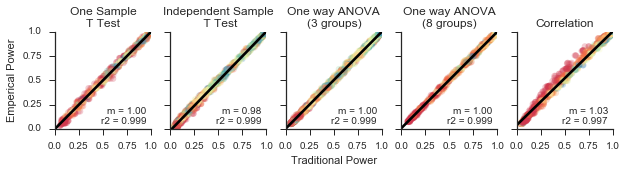

In [10]:
# Sets up the figure and axes
tr_fig, tr_axes = plt.subplots(4, 5)
tr_fig.set_size_inches(10, 8)

# Hides the axes until they're needed
for ax_r in tr_axes[1:]:
    for ax in ax_r:
        ax.set_visible(False)

sn.despine()

for idx, (test_name, ax) in enumerate(zip(*(tests, tr_axes[0]))):
    summary = distributions[test_name]['summary']
    plot.gradient_regression(ax, y='emperical_power', 
                             x='traditional_power', 
                             gradient='color', 
                             data=summary, 
                             alpha=0.25)
    plot.format_regression_axis(ax)
    ax.set_title(summary['clean_name'].values[0])
    ax.set_xticklabels(ax.get_xticks())
tr_axes[0][0].set_yticklabels(ax.get_yticks())
tr_axes[0][0].set_ylabel('Emperical Power')
tr_axes[0][2].set_xlabel('Traditional Power')

We can also look at the fit data behaves. So, we'll add an additional three rows to the plot, which show the 

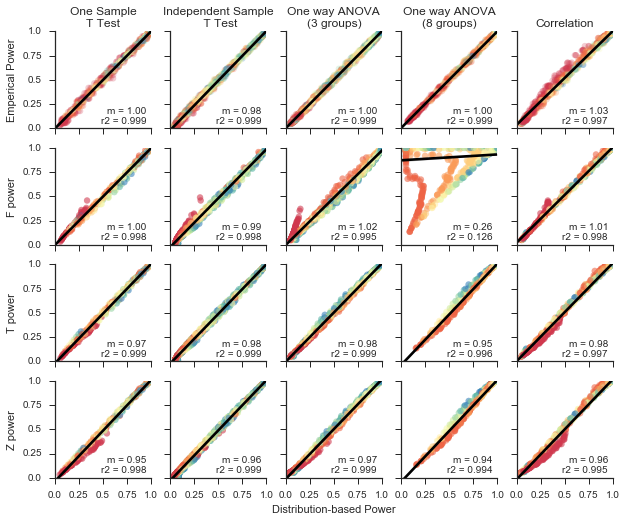

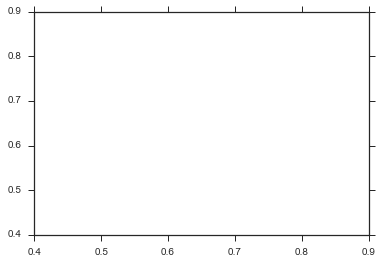

In [11]:
for ax_r in tr_axes[1:]:
    for ax in ax_r:
        ax.set_visible(True)
for ax in tr_axes[0]:
    ax.set_xticklabels('')
    ax.set_xlabel('')
    
for idc, test_name in enumerate(tests):
    summary = distributions[test_name]['summary']
    for metric, ax_reg in zip(*[extrapolated, tr_axes.T[idc][1:]]):
        plot.gradient_regression(ax=ax_reg, 
                            x='traditional_power', 
                            y=metric, 
                            gradient='color', 
                            alpha=0.25,
                            data=summary
                            )
        plot.format_regression_axis(ax_reg)
        if metric == 'z_power':
            ax_reg.set_xticklabels(ax_reg.get_xticks())
        if test_name == tests[0]:
            ax_reg.set_yticklabels(ax_reg.get_yticks())
            ax_reg.set_ylabel(metric.replace('_', ' ').capitalize())
        
tr_axes[-1][2].set_xlabel('Distribution-based Power')
tr_fig

For most of the effect sizes and fits, we find the behavior of the curve 

Let's also compare the behavior of the emperical power and the fit power curves. 

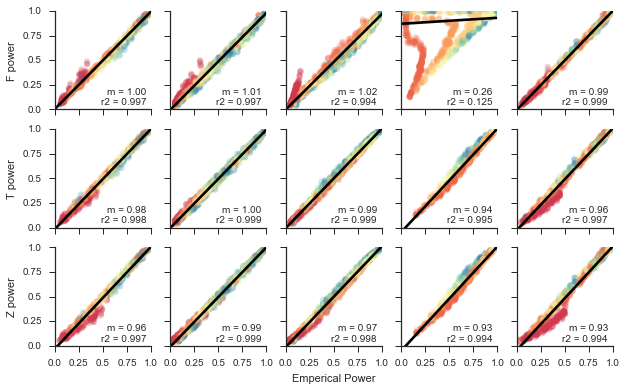

In [12]:
# Sets up the figure and axes
er_fig, er_axes = plt.subplots(3, 5)
er_fig.set_size_inches(10, 6)
sn.despine()

for idc, test_name in enumerate(tests):
    summary = distributions[test_name]['summary']
    for metric, ax_reg in zip(*[extrapolated, er_axes.T[idc]]):
        plot.gradient_regression(ax=ax_reg, 
                            x='emperical_power', 
                            y=metric, 
                            gradient='color', 
                            alpha=0.25,
                            data=summary
                            )
        plot.format_regression_axis(ax_reg)
        if metric == 'z_power':
            ax_reg.set_xticklabels(ax_reg.get_xticks())
        if test_name == tests[0]:
            ax_reg.set_yticklabels(ax_reg.get_yticks())
            ax_reg.set_ylabel(metric.replace('_', ' ').capitalize())
        
er_axes[-1][2].set_xlabel('Emperical Power')

Based on the color by depth, it looks like the emperical power and extrapolated values do not behave as well at lower count values. We can recalculate the fit curves excluding these lower values, to see if this improves the fit.

We also notice that the F distribution with $k - 1$ degrees of freedom does not behave well for the 8 group ANOVA. With fewer groups, the F distribution behaves simillarly to the T and Z distribution. However, as the number of groups increase, the distribution does not behave appropriately. This suggests that the power calculation may be better approximated by assuming a normal distribution than using the approximation based on group size.

Finally, an additional consideration in selecting the appropriate effect size metric is to determine how frequently a particular metric cannot be defined.

In [27]:
all_tests = pd.concat([distributions[test_name]['summary'] for test_name in tests])

In [40]:
all_tests.groupby('test').count()[['f_effect', 't_effect', 'z_effect']] / 3000

,f_effect,t_effect,z_effect
test,,,
anova_3,0.867333,0.890667,0.899000
anova_8,0.378667,0.492000,0.492000
correlation,0.509333,0.528667,0.533333
ttest_1,0.368667,0.380333,0.380333
ttest_ind,0.892000,0.896667,0.928333


...